In [ ]:
pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# #개요
신용카드 이상 거래 탐지 모델 만들기

이상 거래 탐지는 전자상거래 비즈니스에서 한번의 사기에도 많은 손실이 생길 수 있어 매우 중요하다.이에 신용카드 데이터셋을 활용하여 이상거래 탐지 모델을 구축해본다.

데이터셋 출처: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

- 딥러닝
- LGBM
- XGboost
- 로지스틱 회귀

# 1. 데이터셋 확인

In [ ]:
# Load the dataset
file_path = '/content/drive/MyDrive/Colaboratory/메타코드스터디/creditcard.csv'

import pandas as pd
df = pd.read_csv(file_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# 결측치 확인
df.isnull().sum().sum()

0

In [ ]:
# 컬럼확인
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
# Classes 비율
Normal = len(df[df.Class == 0])
Fraud = len(df[df.Class == 1])
Fraud_percent = (Fraud / (Fraud+Normal)) *100

print(df.Class.value_counts())
print('Percentage of Fraud transactions: {:.4f}'.format(Fraud_percent))

Class
0    284315
1       492
Name: count, dtype: int64
Percentage of Fraud transactions: 0.1727


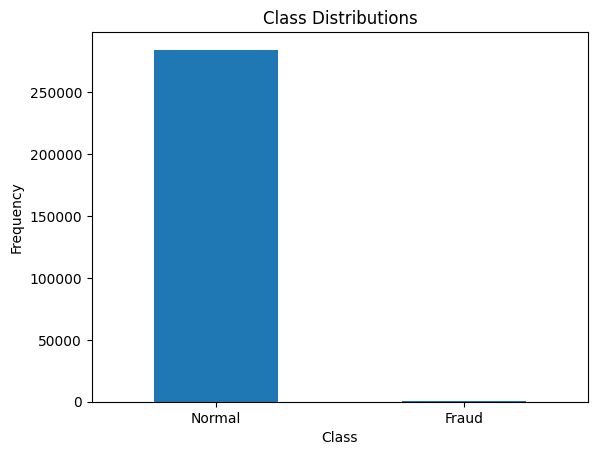

In [ ]:
# Class 분포 시각화
import matplotlib.pyplot as plt
Labels = ['Normal', 'Fraud']

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title('Class Distributions')
plt.xticks(range(2), Labels)
plt.ylabel('Frequency')
plt.show()

정상거래가 99.8% 정도로 클래스 불균형이 매우 심한 것을 알 수 있다.이 데이터를 활용하여 이상거래 탐지 예측 모델을 만들면, 대부분 이상거래가 아니라고 가정하기 때문에 오버피팅 될 가능성이 높다.

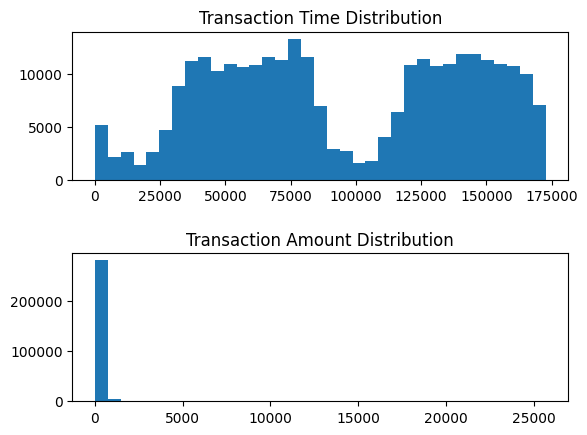

In [ ]:
# Amounts, Time 분포 확인
amount_val = df['Amount'].values
time_val = df['Time'].values

plt.subplot(2,1,1)
plt.title('Transaction Time Distribution')
plt.hist(time_val, bins = 35)

plt.subplot(2,1,2)
plt.title('Transaction Amount Distribution')
plt.hist(amount_val, bins = 35)

plt.subplots_adjust(hspace = 0.5)
plt.show()

In [ ]:
# Class별 Amounts 확인하기
fraud = df[df['Class'] == 1]
normal = df[df['Class'] == 0]

pd.concat([fraud.Amount.describe(), normal.Amount.describe()], axis = 1)

,Amount,Amount
count,492.00,284315.00
mean,122.21,88.29
std,256.68,250.11
min,0.00,0.00
25%,1.00,5.65
50%,9.25,22.00
75%,105.89,77.05
max,2125.87,25691.16


In [ ]:
# Class별 Time 확인하기
pd.concat([fraud.Time.describe(), normal.Time.describe()], axis = 1)

,Time,Time
count,492.00,284315.00
mean,80746.81,94838.20
std,47835.37,47484.02
min,406.00,0.00
25%,41241.50,54230.00
50%,75568.50,84711.00
75%,128483.00,139333.00
max,170348.00,172792.00


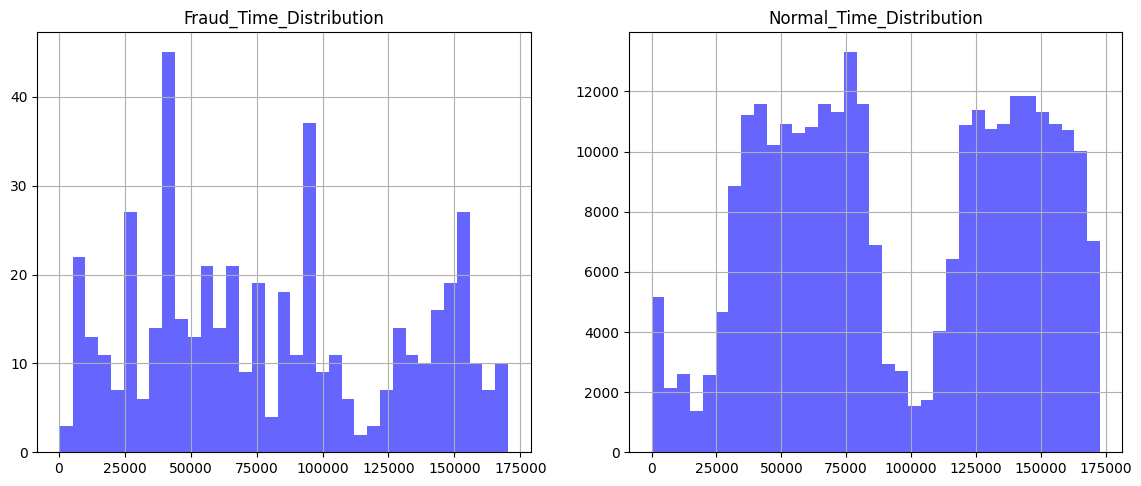

In [ ]:
# Class별 Tim 분포 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
fraud['Time'].hist(bins=35, color='blue', alpha=0.6)
plt.title('Fraud_Time_Distribution')

plt.subplot(2, 2, 2)
normal['Time'].hist(bins=35, color='blue', alpha=0.6)
plt.title('Normal_Time_Distribution')

plt.show()

분포 시각화를 통해 특정 시간대에 거래가 치우쳐져 있음을 확인할 수 있고, 이에 데이터 scaling 필요함을 확인할 수 있다.

# 2. 데이터 전처리

### Scaling

- Min-Max scaling
- Standard scaling
- Robust scaling : 중앙값, 평균편차 이용
- Normalization scaling
- Log scaling
- Exponential scaling

outlier에 강한 Robust Scaler를 사용하였다.
MinMax scaler 또는 Standard Scaler와 같이 평균, 표준편차를 쓰면 이상값에 영향을 많이 받는데 Robust Scaler는 중앙값, 사분위수 값을 사용하여 덜 민감하다.

In [ ]:
# 데이터 표준화 : Robust Scaler
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
df['scaled_amount'] = rs.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rs.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(0, 'scaled_time', scaled_time)
df.head()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.99,1.78,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,...,0.25,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,0
1,-0.99,-0.27,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,...,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,0
2,-0.99,4.98,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,...,0.52,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,0
3,-0.99,1.42,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,...,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,0
4,-0.99,0.67,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,...,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,0


### 데이터 분할

In [ ]:
# 데이터 분할
x = df.drop(["Class"], axis= 1)
y = df["Class"]
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size= 0.2, random_state= 42)
print("Shape of train_X: ", x_train.shape)
print("Shape of test_X: ", x_test.shape)

Shape of train_X:  (227845, 30)
Shape of test_X:  (56962, 30)


### Resampling

- Undersampling
- Oversampling
- SMOTE

클래스 불균형 해결을 위해 Oversampling 기법 중 하나인 SMOTE 방식을 사용한다.(아래 설명)
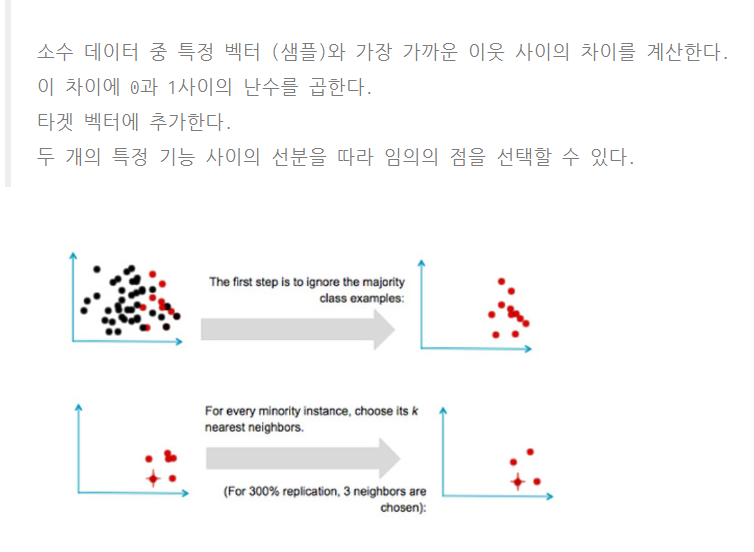

https://mkjjo.github.io/python/2019/01/04/smote_duplicate.html

In [ ]:
# 데이터 불균형 해결: SMOTE
from imblearn.over_sampling import SMOTE
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
x_train_s, y_train_s = sm.fit_resample(x_train, y_train)

print('After OverSampling, the shape of train_x: {}'.format(x_train_s.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_s.shape))

print("After OverSampling, counts of label '1', %: {}".format(sum(y_train_s==1)/len(y_train_s)*100.0,2))
print("After OverSampling, counts of label '0', %: {}".format(sum(y_train_s==0)/len(y_train_s)*100.0,2))

Before OverSampling, counts of label '1': 394
Before OverSampling, counts of label '0': 227451 

After OverSampling, the shape of train_x: (454902, 30)
After OverSampling, the shape of train_y: (454902,) 

After OverSampling, counts of label '1', %: 50.0
After OverSampling, counts of label '0', %: 50.0


Oversampling 하기 이전에는 사기거래가 394건이였는데 이후 454902건으로 정상거래와 거의 동일한 비율로 맞춰진 것을 알 수 있다.

In [ ]:
# 모델 평가지표 함수
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score

def metrics(acutals, predictions):
  print('Accuracy: {:.5f}'.format(accuracy_score(actuals, predictions)))
  print('Precision: {:.5f}'.format(precision_score(actuals, predictions)))
  print('Recall: {:.5f}'.format(recall_score(actuals, predictions)))
  print('F1-score: {.5f}'.format(f1_score(acutals, predictions)))


# 3. 모델링

### Tensorflow 활용한 딥러닝

In [ ]:
n_inputs = x_train_s.shape[1]

In [ ]:
# Before oversampling 모델링
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# 모델 생성
model = Sequential([
    Dense(64, input_shape=(n_inputs, ), activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

# 모델 컴파일: 손실함수, optimizer, 평가지표 지정
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics= ['Precision', 'Recall'])

# 모델 학습
model.fit(x_train, y_train, validation_split=0.2, batch_size=300, epochs=25, shuffle=True, verbose=2)

Epoch 1/25
608/608 - 5s - loss: 0.0340 - precision: 0.0664 - recall: 0.1359 - val_loss: 0.0041 - val_precision: 0.8310 - val_recall: 0.6941 - 5s/epoch - 8ms/step
Epoch 2/25
608/608 - 2s - loss: 0.0066 - precision: 0.8452 - recall: 0.4595 - val_loss: 0.0035 - val_precision: 0.8434 - val_recall: 0.8235 - 2s/epoch - 3ms/step
Epoch 3/25
608/608 - 2s - loss: 0.0053 - precision: 0.8333 - recall: 0.6149 - val_loss: 0.0035 - val_precision: 0.8452 - val_recall: 0.8353 - 2s/epoch - 3ms/step
Epoch 4/25
608/608 - 2s - loss: 0.0050 - precision: 0.8489 - recall: 0.6181 - val_loss: 0.0033 - val_precision: 0.8353 - val_recall: 0.8353 - 2s/epoch - 3ms/step
Epoch 5/25
608/608 - 2s - loss: 0.0040 - precision: 0.8672 - recall: 0.6764 - val_loss: 0.0033 - val_precision: 0.8353 - val_recall: 0.8353 - 2s/epoch - 3ms/step
Epoch 6/25
608/608 - 3s - loss: 0.0041 - precision: 0.8462 - recall: 0.6764 - val_loss: 0.0034 - val_precision: 0.8353 - val_recall: 0.8353 - 3s/epoch - 5ms/step
Epoch 7/25
608/608 - 3s - lo

In [ ]:
# 모델 평가
score = model.evaluate(x_test, y_test, verbose=1)
print('Loss: {:.5f}'.format(score[0]))
print('Precision: {:.5f}'.format(score[1]))
print('Recall: {:.5f}'.format(score[2]))

1781/1781 [==============================] - 4s 2ms/step - loss: 0.0032 - precision: 0.8506 - recall: 0.7551
Loss: 0.00315
Precision: 0.85057
Recall: 0.75510


In [ ]:
# After oversampling 모델링
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# 모델 생성
model2 = Sequential([
    Dense(64, input_shape=(n_inputs, ), activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

# 모델 컴파일: 손실함수, optimizer, 평가지표 지정
model2.compile(optimizer='Adam', loss='binary_crossentropy', metrics= ['Precision', 'Recall'])

# 모델 학습
model2.fit(x_train_s, y_train_s, validation_split=0.2, batch_size=300, epochs=25, shuffle=True, verbose=2)

Epoch 1/25
1214/1214 - 6s - loss: 0.1352 - precision: 0.9485 - recall: 0.9167 - val_loss: 0.0705 - val_precision: 1.0000 - val_recall: 0.9730 - 6s/epoch - 5ms/step
Epoch 2/25
1214/1214 - 4s - loss: 0.0470 - precision: 0.9772 - recall: 0.9801 - val_loss: 0.0245 - val_precision: 1.0000 - val_recall: 0.9945 - 4s/epoch - 3ms/step
Epoch 3/25
1214/1214 - 7s - loss: 0.0266 - precision: 0.9845 - recall: 0.9943 - val_loss: 0.0110 - val_precision: 1.0000 - val_recall: 0.9998 - 7s/epoch - 6ms/step
Epoch 4/25
1214/1214 - 7s - loss: 0.0180 - precision: 0.9893 - recall: 0.9976 - val_loss: 0.0082 - val_precision: 1.0000 - val_recall: 1.0000 - 7s/epoch - 6ms/step
Epoch 5/25
1214/1214 - 10s - loss: 0.0150 - precision: 0.9912 - recall: 0.9984 - val_loss: 0.0046 - val_precision: 1.0000 - val_recall: 1.0000 - 10s/epoch - 9ms/step
Epoch 6/25
1214/1214 - 8s - loss: 0.0124 - precision: 0.9930 - recall: 0.9988 - val_loss: 0.0040 - val_precision: 1.0000 - val_recall: 1.0000 - 8s/epoch - 7ms/step
Epoch 7/25
121

<Axes: >

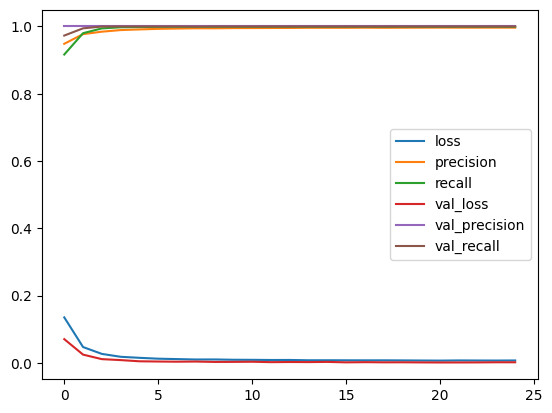

In [ ]:
# 학습 진행별 성능 변화 시각화
model2_loss = pd.DataFrame(model2.history.history)
model2_loss.plot()

In [ ]:
# 모델 평가
score2 = model2.evaluate(x_test, y_test, verbose = 1)
print('Loss: {:.5f}'.format(score2[0]))
print('Precision: {:.5f}'.format(score2[1]))
print('Recall: {:.5f}'.format(score2[2]))

1781/1781 [==============================] - 5s 3ms/step - loss: 0.0217 - precision: 0.6748 - recall: 0.8469
Loss: 0.02172
Precision: 0.67480
Recall: 0.84694


#### 3-1. XGboost

In [ ]:
from xgboost import XGBClassifier
# 모델 생성
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train, eval_metric = 'recall', 'f1-score')

# 모델 예측
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

# 모델 평가
print_score(y_train, y_train_pred, train = True)
print_score(y_test, y_test_pred, train = False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


NameError: name 'print_score' is not defined

train 데이터 정확도는 100%, test 데이터 정확도는 99.96% 나온 것을 볼 수 있다. Class 1의 정밀도, 재현율이 비교적 낮게 나온 것을 알 수 있다. **1의 정밀도가 낮다는건 이상거래로 예측한 거래 중에서 실제 이상거래가 아닌 경우가 많다는 것이고, 재현율이 낮다는 것은 실제 이상거래 중에서 모델이 예측한 이상거래 비율이 낮다는 것이다.**

재현율 (Recall): 이 값은 실제로 이상거래인 케이스 중에서 모델이 식별한 이상거래의 비율을 나타냅니다. 재현율이 낮다는 것은 모델이 이상거래를 덜 찾아낸다는 것을 의미합니다. 즉, 이상거래 중 많은 부분을 놓치고 있다는 것을 나타냅니다. 이는 거래 중에서 사기 거래를 식별하는 것이 중요한 경우에는 심각한 문제가 될 수 있습니다.
정밀도 (Precision): 이 값은 모델이 이상거래로 예측한 거래 중에서 실제로 이상거래인 거래의 비율을 나타냅니다. 정밀도가 낮다는 것은 모델이 이상거래로 잘못 분류하는 경우가 많다는 것을 의미합니다. 즉, 모델이 이상거래로 판단한 거래 중에서 실제로는 이상거래가 아닌 경우가 많다는 것을 나타냅니다.



---



*   에폭: 1에폭은 학습에서 인공신경망에서 전체 데이터셋에 대해 forward/backward 과정을 거친 것을 말함.(전체 데이터셋에 대해 한번 학습을 완료한 상태)
  * backpropagation algorithm은 입력부터 출력까지의 각 계층 weight 계산을 해주는 순방향 패스, 거슬러 올라가며 다시 계산해서 기존 weight를 수정하는 역방향 패스로 나뉜다. 1에폭은 순방향+역방향 한번을 포함한 의미이다.

  - epoch이 너무 크면 overfitting, 너무 작으면 underfitting이 발생할 수 있어 적절하게 설정 해야한다.

* 배치사이즈: 한번의 배치마다 주는 데이터 샘플의 사이즈.
* Iteration: 에폭을 나누어서 실행하는 횟수.
  - 예를들어 1000개의 데이터셋을, 한턴에 1000개씩 10번, 5턴 학습시킨다고 할 때,
  batch_size = 1000, iteration = 10, epoch = 5가 된다.

  https://jonhyuk0922.tistory.com/129




In [ ]:
#

In [ ]:
# 모델 평가
score = model.evaluate(X_test, y_test)
print(score)

1781/1781 [==============================] - 5s 2ms/step - loss: 0.0472 - fn: 97.0000 - fp: 29.0000 - tn: 56835.0000 - tp: 1.0000 - precision: 0.0333 - recall: 0.0102
[0.04721889644861221, 97.0, 29.0, 56835.0, 1.0, 0.03333333507180214, 0.010204081423580647]


Try 2)

In [ ]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[-1],)),  # 더 많은 뉴런 추가
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),  # 드롭아웃 비율 증가
    keras.layers.Dense(512, activation='relu'),  # 더 많은 뉴런 추가
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),  # 드롭아웃 비율 증가
    keras.layers.Dense(512, activation='relu'),  # 더 많은 뉴런 추가
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),  # 드롭아웃 비율 증가
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

# 모델 컴파일 : 손실함수, optimizer, 평가지표 지정
METRICS = [
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=METRICS)

# 모델 훈련
history = model.fit(X_train, y_train, batch_size=128, epochs=100)  # 배치 크기 증가, 에폭 수 증가


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               16896     
                                                                 
 batch_normalization_9 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_10 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 512)              

In [ ]:
# 모델 평가
score = model.evaluate(X_test, y_test)
print(score)

1781/1781 [==============================] - 7s 3ms/step - loss: 0.0238 - fn: 96.0000 - fp: 13.0000 - tn: 56851.0000 - tp: 2.0000 - precision: 0.1333 - recall: 0.0204
[0.023786723613739014, 96.0, 13.0, 56851.0, 2.0, 0.13333334028720856, 0.020408162847161293]


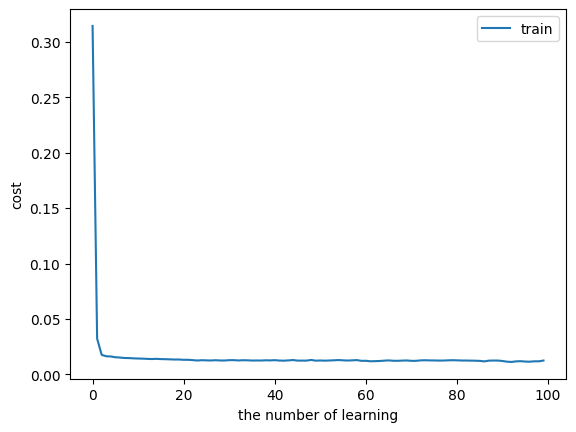

In [ ]:
# 시각화
plt.plot(history.history['loss'], label = 'train')
plt.xlabel('the number of learning')
plt.ylabel('cost')
plt.legend()
plt.show()

[RNN & XGboost 모델 비교- Kaggle 링크](https://www.kaggle.com/code/faressayah/credit-card-fraud-detection-anns-vs-xgboost)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")

    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n")

**1) 로지스틱 회귀 분석**

In [ ]:
# 로지스틱 회귀 필요한 모듈 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 모델 생성
log_reg_model = LogisticRegression()

# 모델 훈련
log_reg_model.fit(X_train, y_train)

# 모델 예측
y_pred = log_reg_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 로지스틱 회귀 모델 생성
log_reg_model = LogisticRegression()

# 모델 훈련
log_reg_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = log_reg_model.predict(X_test)

# 정확도 출력
print("Accuracy:", accuracy_score(y_test, y_pred))

# 혼동 행렬 출력
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 분류 보고서 출력
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9989817773252344

Confusion Matrix:
[[56840    24]
 [   34    64]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.65      0.69        98

    accuracy                           1.00     56962
   macro avg       0.86      0.83      0.84     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
# 모델 예측

In [ ]:
# 모델 평가

# 3. Feature Scaling
###### 하는 이유?
###### 변수 값의 범위 또는 단위가 달라서 발생 가능한 문제를 예방할 수 있다.
###### 머신러닝 모델이 특정 데이터의 편향성을 갖는 걸 방지할 수 있다.
###### 데이터 범위 크기에 따라 모델이 학습하는 데 있어서 bias가 달라질 수 있으므로 하나의 범위 크기로 통일해주는 작업이 필요할 수 있다
출처: https://glanceyes.com/entry/데이터-전처리의-피처-스케일링Feature-Scaling [지그시:티스토리]

Feature Scaling 시 유의사항

###### 학습 데이터로 fit(), transform()을 적용한 후 테스트 데이터에서 다시 fit()을 수행하지 않고 학습 데이터로 fit()을 적용한 결과를 이용해서 transform()을 적용해야 한다.

###### 머신러닝 모델이 학습 데이터(train set)에 관해서만 학습을 해야 하는데, 오직 평가에서만 사용해야 할 테스트 데이터(test set)를 머신러닝 모델이 학습을 하게 되면 모델의 성능을 제대로 평가할 수 없다. 테스트 데이터로 다시 새로운 스케일링 기준을 만들어서 학습해 버리면 스케일링 기준 정보가 학습 데이터에서의 기준과 달라질 수 있어서다.

###### 정리하면, 머신러닝 모델은 학습 데이터를 기반으로 학습이 되므로 반드시 테스트 데이터는 학습 데이터의 스케일링 기준을 따라야 한다. 따라서 테스트 데이터에는 다시 fit()을 적용해서는 안 된다.
출처: https://glanceyes.com/entry/데이터-전처리의-피처-스케일링Feature-Scaling [지그시:티스토리]

1. Min-Max scaling
2. Standard scaling
3. Robust scaling : 중앙값, 평균편차 이용
4. Normalization scaling
5. Log scaling
6. Exponential scaling

In [ ]:
# Robust scaling 객체 생성
scaler = RobustScaler()

# Robust scaling 정규화
X_train['scaled_amount'] = scaler.fit_transform(X_train['Amount'].values.reshape(-1, 1))
X_test['scaled_amount'] = scaler.transform(X_test['Amount'].values.reshape(-1, 1))

X_train['scaled_time'] = scaler.fit_transform(X_train['Time'].values.reshape(-1, 1))
X_test['scaled_time'] = scaler.transform(X_test['Time'].values.reshape(-1, 1))

# 확인
print('\n=======================스케일링 전=======================')
print("Data - Mean:")
print(X_train[['Amount', 'Time']].mean())
print("\nData - Variance:")
print(X_train[['Amount', 'Time']].var())
print('\n=======================스케일링 후=======================')
print("Scaled Data - Mean:")
print(X_train[['scaled_amount', 'scaled_time']].mean())
print("\nScaled Data - Variance:")
print(X_train[['scaled_amount', 'scaled_time']].var())


=======================스케일링 전=======================
Data - Mean:
Amount       88.479993
Time      94792.551673
dtype: float64

Data - Variance:
Amount    6.498945e+04
Time      2.255155e+09
dtype: float64

=======================스케일링 후=======================
Scaled Data - Mean:
scaled_amount    0.929790
scaled_time      0.118453
dtype: float64

Scaled Data - Variance:
scaled_amount    12.712494
scaled_time       0.311077
dtype: float64


# 데이터불균형 해결

# 이상치 제거

# 변수별 상관관계 확인